# Klastering

In [1]:
# Manipulasi data
import pandas as pd

# Text preprocessing
import re
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Representasi vektor dan clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Evaluasi kualitas cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK resource (tokenizer dan stopword)
import nltk


In [2]:
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [3]:
# Import Data
df=pd.read_csv('Data/Review_data.csv')

In [4]:
df

,review_body,star_rating
0,Good luck finding a reasonably priced band rep...,1
1,No i get dark on the first week with me!! I wi...,1
2,I dont know if mine was a mistake but it clear...,1
3,The rod that holds the bracelet broke several ...,1
4,"I bought 2 watches , one watch doesnot work at...",1
...,...,...
14995,"I have a TAG Heuer carrera twin time watch, wh...",5
14996,It is hard sometimes to judge a product by its...,5
14997,reloj en perfecto estado llego todo a tiempo l...,5
14998,This is my third ironman. There are more expe...,5


In [5]:
# menampilkan jumlah data yang hilang pada setiap kolom
df.isnull().sum()

review_body    0
star_rating    0
dtype: int64

# Preprocessing Data

In [6]:
# Take only the review_body column for unsupervised learning task
data = df.loc[:, 'review_body'].tolist()

# Print stopwords info
stopwords = stopwords.words('english')

**Noted**

Kode ini mengambil data dari kolom review_body pada DataFrame df dan mengubahnya menjadi list (data). Ini dilakukan karena kita hanya membutuhkan isi review untuk tugas unsupervised learning (clustering), bukan kolom lain.

In [7]:
def text_preprocessing(text):
    
    # Remove punctuation characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Create a instance of stem class
    stemmer = SnowballStemmer("english")
    
    clean_tokens = []
    for word in tokens:
        clean_tok = stemmer.stem(word).lower().strip()
        if clean_tok not in stopwords:
            clean_tokens.append(clean_tok)

    return clean_tokens


**Noted**

- removepunctuation --> Menghilangkan tanda baca dan angka, hanya menyisakan huruf.

- Tokenize --> Memecah kalimat jadi kata-kata (tokenize).

- Stemming --> Melakukan stemming untuk mengubah kata ke bentuk dasarnya (misalnya “running” → “run”).

- stopword removal --> Menghilangkan kata-kata umum yang masuk daftar stopwords agar fokus pada kata penting.

In [ ]:
# Membuat model TF-IDF dengan parameter:
tfidf_model = TfidfVectorizer(
    max_df=0.95,     
    max_features=1000, 
    min_df=0.15,      
    use_idf=True,    
    tokenizer=text_preprocessing, 
    ngram_range=(1,1) 
)

# Menerapkan TF-IDF vectorizer ke data review
tfidf_matrix = tfidf_model.fit_transform(data)

c:\Users\Acer-Nitro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Noted**
- max_df=0.95: abaikan kata yang muncul di lebih dari 95% dokumen (terlalu umum).

- min_df=0.15: abaikan kata yang muncul kurang dari 15% dokumen (terlalu jarang).

- max_features=1000: hanya ambil 1000 kata paling penting untuk efisiensi.

- tokenizer=text_preprocessing: gunakan fungsi preprocessing yang sudah dibuat.

- ngram_range=(1,1): hanya kata tunggal (unigram).

- Matriks TF-IDF (dokumen x kata), siap untuk clustering.

In [9]:
# Words
tf_selected_words = tfidf_model.get_feature_names_out()
tfidf_matrix

<15000x11 sparse matrix of type '<class 'numpy.float64'>'
	with 39413 stored elements in Compressed Sparse Row format>

**Noted**
- Mengambil daftar kata-kata yang menjadi fitur dalam model TF-IDF.

- tfidf_matrix menyimpan representasi dokumen dalam bentuk vektor TF-IDF.

- Tujuan: Memastikan kata yang dianalisis dan melihat matriks fitur.

# Training Model

In [ ]:
# Melatih KMeans clustering dengan jumlah cluster 3
kmeans_model = KMeans(n_clusters=3, random_state=42)
cluster =kmeans_model.fit_predict(tfidf_matrix)

# Evaluasi Model

In [ ]:
# Calculate Davies-Bouldin score semakin rendah semakin baik
db_score = davies_bouldin_score(tfidf_matrix.toarray(), cluster)
print(f"Davies-Bouldin Score: {db_score:.4f}")

# Calculate Silhouette score for comparison semakin tinggi semakin baik
silhouette_avg = silhouette_score(tfidf_matrix.toarray(), cluster)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Davies-Bouldin Score: 2.4260
Silhouette Score: 0.1624


**Noted**

seperti yang terlihat hasil dari Davies-Bouldin scor dan Calculate Silhouette score kurang bagus. karena Davies-Bouldin Score masih cukup tinggi, dan Silhouette score masih cukup rendah

# Visualisasi

In [12]:
clusters = kmeans_model.labels_.tolist()
df['cluster'] = clusters

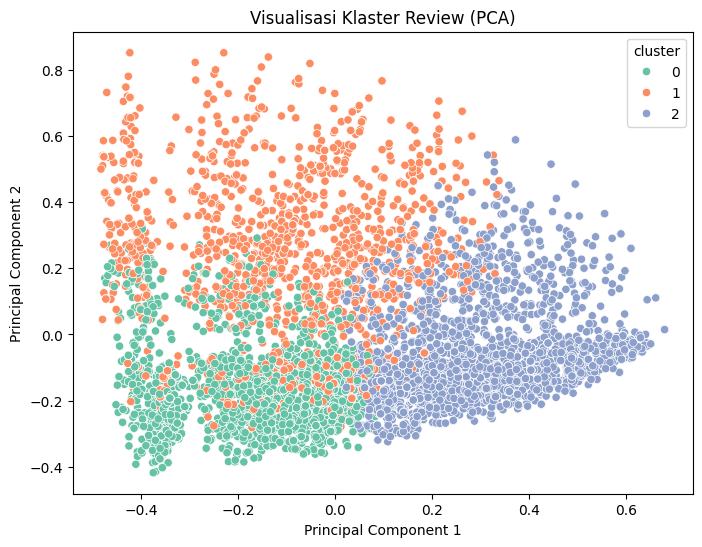

In [13]:
# Reduksi dimensi dari ratusan fitur TF-IDF menjadi 2D menggunakan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

# Buat plot scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='Set2')
plt.title('Visualisasi Klaster Review (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


**Noted** 

Visualisasi PCA menunjukkan bahwa hasil klasterisasi berhasil mengelompokkan review ke dalam tiga klaster utama. Klaster 2 memiliki karakteristik yang paling berbeda, sementara klaster 0 dan 1 memiliki kemiripan. Ini menunjukkan adanya variasi yang jelas dalam isi review, namun sebagian review masih memiliki konten yang tumpang tindih antar klaster.